In [1]:
import numpy as np
from matplotlib import pyplot as plt

#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
matplotlib.rcParams['figure.figsize'] =  (8,5)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['font.family'] = 'serif'

np.random.seed(0)
import sys
sys.path.append('/Users/danmarthaler/GPclust')

#Mixture of Gaussians with GPclust

###James Hensman, November 2014
###Daniel Marthaler September 2016

This is a very simple demo to show how to use GPclust to build a mixture of Gaussians. We'll grab some toy data, fit the model and do some very simple analyis of the posterior. We'll also have a look at the truncated Dirichlet process approximation, and how to run a merge-split method to find the optimal number of clusters. Finally we'll examine the effect of changing the priors over the cluster components. 

In [2]:
X = np.load('twoD_clustering_example.numpy')
print X.shape

(506, 2)


We have a two-dimensional dataset, with 506 data.

Building the model is as simple as importing the GPclust library and calling the class constructor with our data. The argument num_clusters specifies how many clusters to use.

In [3]:
import GPclust
m = GPclust.MOG(X, num_clusters=10)

IndentationError: unexpected indent (MOG.py, line 112)

For two-dimensional data, there's a handy built-in plot function:

In [4]:
from matplotlib import pyplot as plt
#plt.figure()
xmin, ymin = X.min(0)
xmax, ymax = X.max(0)
xmin, xmax = xmin-0.1*(xmax-xmin), xmax+0.1*(xmax-xmin)
ymin, ymax = ymin-0.1*(ymax-ymin), ymax+0.1*(ymax-ymin)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
Xgrid = np.vstack((xx.flatten(), yy.flatten())).T
print Xgrid.shape
zz = m.predict(Xgrid).reshape(100, 100)
zz_data = m.predict(X)

plt.contour(xx, yy, zz, [stats.scoreatpercentile(zz_data, 5)], colors='k', linewidths=3)
plt.scatter(X[:,0], X[:,1], 30, np.argmax(m.get_phi(), 1), linewidth=0, cmap=plt.cm.gist_rainbow)

zz_components = m.predict_components(Xgrid)
phi_hat = m.get_phihat()
pie = phi_hat+m.alpha
pie /= pie.sum()
zz_components *= pie[np.newaxis,:]
[plt.contour(xx, yy, zz.reshape(100, 100), [stats.scoreatpercentile(zz_data, 5.)], colors='k', linewidths=1) for zz in zz_components.T]
plt.show()

(10000, 2)


NameError: name 'm' is not defined

Here, the data are colored according to the (most probably) assigned cluster, and the heavy line(s) show the contours of the models probability density. Thin lines show the countours of the probablity density of each component.

We can see that the model has not been fitted yet! The variational approximation to the posterior is initialized randomly, i.e. all data are randomly assigned across the clusters. To fit the approximation, call the optimize routine, and plot again. 

In [5]:
m.optimize()

(2, 2, 10) (10,) (?, ?) (?,)
iteration 1 bound=-inf grad=324.960807531, beta=0
iteration 2 bound=-inf grad=562.735331325, beta=0.86781306773
iteration 3 bound=-inf grad=357.850823816, beta=0.261338316849
iteration 4 bound=-inf grad=161.009923565, beta=0.210683580362
iteration 5 bound=-inf grad=71.3818918688, beta=0.210422731077
iteration 6 bound=-inf grad=43.2025971551, beta=0.294475416025
iteration 7 bound=-inf grad=13.380023621, beta=0.140816094457
iteration 8 bound=-inf grad=3.63013237219, beta=0.130815590273
iteration 9 bound=-inf grad=0.777821237788, beta=0.103598087753
iteration 10 bound=-inf grad=0.572655419381, beta=0.358324460768
iteration 11 bound=-inf grad=0.14202137688, beta=0.113589884342
iteration 12 bound=-inf grad=0.00203995185299, beta=0.00696730513164
iteration 13 bound=-inf grad=1.25909193576e-07, beta=3.08055630387e-05
vb converged (gtol)


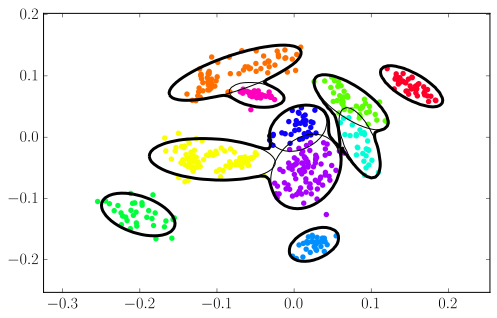

In [6]:
#m.plot()

#Dirichlet process priors and the merge-split method
Instead of using a fixed number of clusters, we can place a Dirichlet process prior over the component weights: effectively a prior of an infintie number of clusters. The variational approximation is _truncated_ se we still only model a finite number of clusters, but now we can optimize for the number of components.

To help explore the search space, GPclust has a `try_split` function. This re-initialized the posterior with a cluster 'split' into two. Attempted splits are only accepted if the bound onthe marginal likelihood increases.  A wrapper around the `try_split()`, method, `systematic_splits()` repeatedly attempts splits. 

Let's build a MOG with a DP prior, truncated at four components:

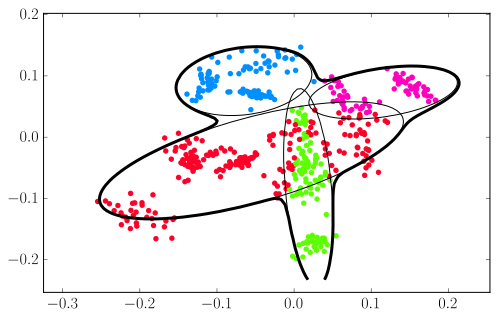

In [7]:
m = GPclust.MOG(X, K=4, prior_Z='DP', alpha=10.)
m.optimize()
m.plot()

With only four components, the fit is quite poor. To attempt to split the $i^\textrm{th}$ component, call `try_split(i)`. The method returns `True` if the split was sucessful, and displays the current status after each split attempt. 

In [8]:
m.try_split(1)

('\nattempting to split cluster ', 1)
('split suceeded, bound changed by: ', 58.793588398107659, ',', 1, ' new clusters', '(K=5)')
optimizing new split to convergence:


True

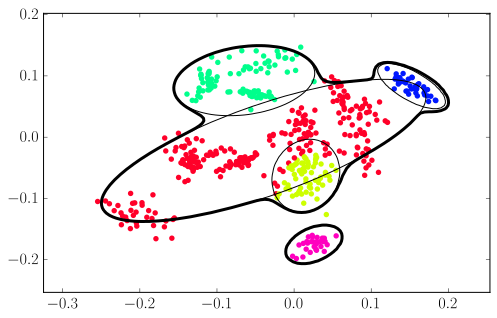

In [9]:
m.plot()

We can see that in attempting to split the first cluster, the bound on the marginal likelihood has increased and the move was accepted. To save having to repeatedly call the `try_split` method, there's a helpful `systematic_splits()` function, which iterates through each cluster and attempts to split it until the marginal-likelihood bound fails to increase. Here we'll turn the output off, as it can get a bit long.

In [10]:
m.systematic_splits(verbose=False)

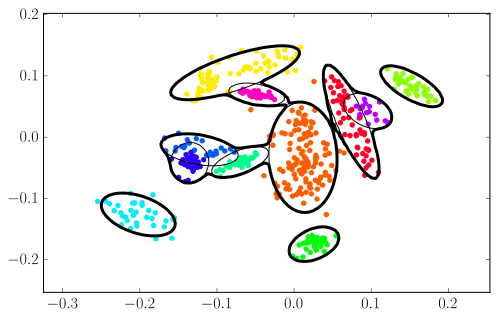

In [11]:
m.plot()

##Getting at the parameters of the posterior. 
There are perhaps three main tasks that we'd like to do with the fitted model:
* See which data are assigned to the same cluster
* Examine the means (and variances) of the cluster components
* Predict the probability density at a new point

The posterior over data assignments is stored in a matix called `phi`. This matrix is NxK, and each element $\phi_{nk}$ represents the probability that the $n^\textrm{th}$ datum is assigned to the $k^\textrm{th}$ component. Here we'll visualize the posterior assignment probabilities in a heatmap-style plot.

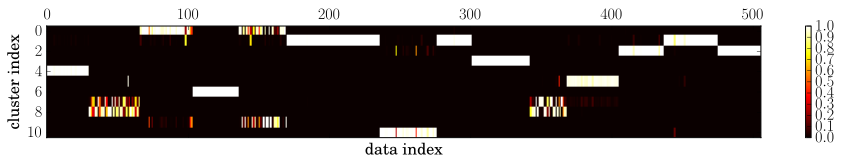

In [12]:
phi = m.phi
_=plt.matshow(phi.T, cmap=plt.cm.hot, vmin=0, vmax=1, aspect='auto')
plt.xlabel('data index')
plt.ylabel('cluster index')
_=plt.colorbar()

The variational posterior for each of the components in the MOG model is a Gaussian-Wishart distribution. These are stored in the model as so:

In [13]:
print 'first component mean:', m.mun[:,0]
print 'first component covariance:\n', m.Sns[:,:,0]

first component mean: [ 0.07422406  0.02492751]
first component covariance:
[[ 0.0158891  -0.03426786]
 [-0.03426786  0.10578672]]


Finally, to obtain the predictive density of the model at any point, we can use `m.predict`. To get the density under each of the components, we can use `m.predict_components'.

In [14]:
test_point = np.array([[0.1, 0.0]])
density = m.predict(test_point)
print 'model density:',density

cw_density = m.predict_components(test_point)
print 'density under each component:', cw_density.round(3)


model density: [ 6.13456833]
density under each component: [[  5.58920000e+01   2.00000000e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.05150000e+01   0.00000000e+00]]


##Adjusting the prior parameters
The MOG model has priors over the component means and covariances (Gaussian Wishart) and a Dirichlet (or Dirichlet-process) prior over the mixing proportions. We'll use the 2D dataset to illustrate how to change these prior parameters and the effect of them. 

First, let's place a strong prior over the cluster covariances that forces them to be small, and a large concentration parameter, which makes the Dirichlet process prefer a large number of clusters. 



bound on the marginal likelihood: 3254.36378158


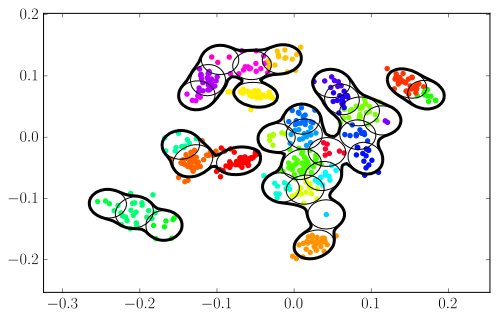

In [15]:
m = GPclust.MOG(X, K=10, prior_S=np.eye(2)*5e-3, prior_v=30., prior_Z='DP', alpha=100)
m.optimize(verbose=False)
m.systematic_splits(verbose=False)
m.systematic_splits(verbose=False)
m.plot()
print 'bound on the marginal likelihood:', m.log_likelihood()

We see that the model finds a very large number of small clusters! Now let's see what happens if we relax the concentration parameter, and reduce the strength of the Wishart prior:

bound on the marginal likelihood: 1548.07214763


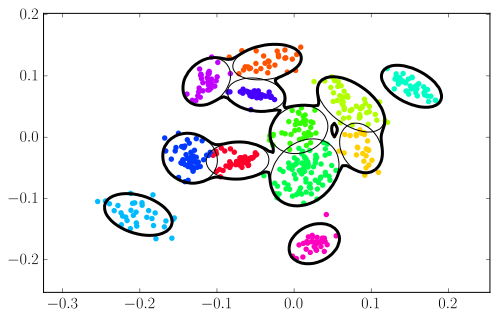

In [16]:
m = GPclust.MOG(X, K=10, prior_S=np.eye(2)*5e-3, prior_v=10., prior_Z='DP', alpha=0.1)
m.optimize(verbose=False)
m.systematic_splits(verbose=False)
m.systematic_splits(verbose=False)
m.plot()
print 'bound on the marginal likelihood:', m.log_likelihood()

The MOG also takes a prior mean parameter (which defalts to the mean of the data) and a prior concentration parameter as part of the Wishart distribution. We leave experimenting with these to the reader. 